### Installs and imports

In [60]:
%%capture
#Assignment 2 COMP 551
#Imports

%pip install pandas
%pip install matplotlib
%pip install seaborn 
%pip install nltk
%pip install scikit-learn

import os
import tarfile
import seaborn as sns
import pandas as pd
import string
import re
import numpy as np
import nltk
import random
import csv

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import vstack 
from scipy.sparse import diags 
from sklearn.datasets import load_svmlight_file
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#random seed for reproducibility
random.seed(42)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# IMDB Dataset

In [61]:
# set the directory to the dataset
dir = 'aclImdb'

# read IMDb vocabulary
vocab = pd.read_csv("aclImdb/imdb.vocab", header=None)

# rename the only column
vocab.columns = ["Word"]

# first 5 entries
vocab.head()
# len(vocab)

,Word
0,the
1,and
2,a
3,of
4,to


In [62]:
# working with the already processed Bag of Words files
X_train, y_train = load_svmlight_file("aclImdb/train/labeledBow.feat")
X_test, y_test = load_svmlight_file("aclImdb/test/labeledBow.feat")

In [63]:
word_df = np.zeros(vocab.shape[0])
# loop through both X_train and X_test
for dataset in (X_train, X_test):
  # loop through every input in either X_train or X_test
  for input in dataset:
    used_words = np.bincount(input.indices, minlength=89527)
    word_df += used_words

word_df /= 50000 # to get frequencies

In [64]:
word_df

array([9.9118e-01, 9.6594e-01, 9.6648e-01, ..., 2.0000e-05, 2.0000e-05,
       2.0000e-05])

In [65]:
print(len(word_df))

89527


In [66]:
# find rare words and stop words in the vocabulary
filtered_vocab = np.logical_or(word_df < 0.01, word_df > 0.5) # creates a Boolean mask whether or not the word in the df meets the criteria

# filter out the above words
removed_feature_words = vocab[filtered_vocab] # apply the mask to the vocabulary
vocab = vocab[np.logical_not(filtered_vocab)]

# print removed words
print("Removed words: ")
print(removed_feature_words)

# print remaining words
print("Remaining words: ")
print(vocab)

# re-index the vacabulary after the filtering
vocab.reset_index(inplace=True, drop=True)

Removed words: 
                    Word
0                    the
1                    and
2                      a
3                     of
4                     to
...                  ...
89522          copywrite
89523             artbox
89524          kinky-sex
89525           urrrghhh
89526  investigator-like

[87791 rows x 1 columns]
Remaining words: 
            Word
21            he
23           his
27             !
30            by
31            an
...          ...
2012  references
2014       stock
2039       board
2047      leader
2051       plots

[1736 rows x 1 columns]


In [67]:
print("Shape of X_train:", X_train.shape)
print("Length of filtered_vocab:", len(filtered_vocab))

Shape of X_train: (25000, 89527)
Length of filtered_vocab: 89527


In [68]:
X_train = X_train@diags(np.logical_not(filtered_vocab).astype(int))

In [69]:
indices = np.nonzero(X_train)
columns_to_keep_non_unique = indices[1]
columns_to_keep_unique = sorted(set(columns_to_keep_non_unique))
X_train = X_train[:,columns_to_keep_unique]

In [70]:
X_test = X_test@diags(np.logical_not(filtered_vocab[:-4]).astype(int))
indices = np.nonzero(X_test)
columns_to_keep_non_unique = indices[1]
columns_to_keep_unique = sorted(set(columns_to_keep_non_unique))
X_test = X_test[:,columns_to_keep_unique]

In [71]:
# merge the y's into a single vertical output vector
all_y = np.concatenate((y_train, y_test)).reshape(-1, 1)

# standardize the output vector
standardized_y = StandardScaler().fit_transform(all_y)

# visualize the result's shape as a sanity check
print(standardized_y.shape)

(50000, 1)


In [72]:
# merge the X's into a single matrix too
all_X = vstack((X_train, X_test)).toarray()

# standardize the output vector
standardized_X = StandardScaler().fit_transform(all_X)

# visualize the result's shape as a sanity check
print(standardized_X.shape)

(50000, 1736)


In [73]:
# standardize the y values
standardized_y_train = StandardScaler().fit_transform(y_train.reshape(-1, 1))
standardized_y_test = StandardScaler().fit_transform(y_test.reshape(-1, 1))

# standardize the X values
standardized_X_train = StandardScaler().fit_transform(X_train.toarray())
standardized_X_test = StandardScaler().fit_transform(X_test.toarray())

# check the dimensions of the resulting arrays
print("X_train shape:", standardized_X_train.shape)
print("y_train shape:", standardized_y_train.shape)
print("X_test shape:", standardized_X_test.shape)
print("y_test shape:", standardized_y_test.shape)

X_train shape: (25000, 1736)
y_train shape: (25000, 1)
X_test shape: (25000, 1736)
y_test shape: (25000, 1)


## Implementing Linear Regression for feature selection

In [74]:
class LinearRegression:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # reshape y to ensure compatibility
        y = y.reshape(-1)  # Convert y to a 1D array

        # gradient descent
        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            # calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))  # shape: (n_features,)
            db = (1 / n_samples) * np.sum(y_pred - y)         # shape: Scalar

            # update weights and bias
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [75]:
model = LinearRegression()
model.fit(standardized_X_train, standardized_y_train)

In [76]:
coefficients = model.weights

In [77]:
# extract the 100 words with the most postive coefficients
most_positive_word_indices = np.argsort(-coefficients) # We use - so that the most positive become the most negative and appear first
most_positive_words = vocab.iloc[most_positive_word_indices[:100]]

# append their corresponding coefficients to the dataframe as a column
most_positive_words["Regression coefficient"] = (-np.sort(-coefficients)[:100]).tolist()
most_positive_words

/var/folders/gw/q9__8xrj4qj1gdn368k40my40000gn/T/ipykernel_97632/1166546628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_positive_words["Regression coefficient"] = (-np.sort(-coefficients)[:100]).tolist()


,Word,Regression coefficient
56,great,0.055175
88,best,0.046501
282,excellent,0.043752
342,wonderful,0.036544
410,loved,0.035286
...,...,...
895,unique,0.011346
1146,thanks,0.011334
1722,captured,0.011325
1291,stunning,0.011261


In [78]:
# 100 words with the most negative coefficients
most_negative_word_indices = np.argsort(coefficients)
most_negative_words = vocab.iloc[most_negative_word_indices[:100]]

# append their corresponding coefficients to the dataframe as a column
most_negative_words["Regression coefficient"] = np.sort(coefficients)[:100].tolist()

# print the results
most_negative_words

/var/folders/gw/q9__8xrj4qj1gdn368k40my40000gn/T/ipykernel_97632/3612209038.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_negative_words["Regression coefficient"] = np.sort(coefficients)[:100].tolist()


,Word,Regression coefficient
213,worst,-0.074413
50,bad,-0.059284
400,waste,-0.057946
341,awful,-0.045368
733,avoid,-0.037273
...,...,...
532,obvious,-0.011702
730,stay,-0.011646
328,half,-0.011644
1293,d,-0.011620


## Implementing Logistic Regression

In [79]:
class LogisticRegression:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_y_pred = X.dot(self.weights) + self.bias
            logistic_y_pred = self.sigmoid(linear_y_pred)

            dw = (1 / n_samples) * X.T.dot(logistic_y_pred - y)
            db = (1 / n_samples) * np.sum(logistic_y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_y_pred = X.dot(self.weights) + self.bias
        logistic_y_pred = self.sigmoid(linear_y_pred)
        class_pred = np.where(logistic_y_pred > 0.5, 1, 0) 
        return class_pred

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


In [80]:
# select the top 100 features based on coefficients
top_100_features_indices = np.argsort(coefficients)[-100:][::-1]

# create a mask array to select columns corresponding to the top features
mask = np.zeros(X_train.shape[1], dtype=bool)
mask[top_100_features_indices] = True

# apply the mask to select the top features from X_train
X_train_top_100 = X_train[:, mask]

In [81]:
X_test_selected_features = X_test[:, top_100_features_indices]

In [82]:
threshold = 5
y_test_binary = np.where(y_test > threshold, 1, 0)
y_train_binary = np.where(y_train > threshold, 1, 0)
y_test_binary

array([1, 1, 1, ..., 0, 0, 0])

In [83]:
# train a logistic regression model on the training data
logistic_regression_model = LogisticRegression(lr=0.001, n_iters=1000)
logistic_regression_model.fit(X_train, y_train_binary)

In [84]:
y_pred = logistic_regression_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 0, 0])

In [85]:
def accuracy1(y_pred, y_test):
    return np.sum(y_pred == y_test) / len(y_test)

acc = accuracy1(y_pred, y_test_binary)
print("Logistic Regression Accuracy:", acc)

Logistic Regression Accuracy: 0.75948


In [86]:
# create the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# fit the model
dt_classifier.fit(X_train, y_train_binary)

# predict
dt_y_pred = dt_classifier.predict(X_test)

# calculate accuracy
dt_acc = accuracy_score(y_test_binary, dt_y_pred)
print("Decision Tree Accuracy:", dt_acc)


Decision Tree Accuracy: 0.69996


## Plots

In [87]:
%%capture
# top 10 words with the most postive coefficients
top_10_indices = np.argsort(-coefficients) # We use - so that the most positive become the most negative and appear first
top_10 = vocab.iloc[top_10_indices[:10]]

# append their corresponding coefficients to the dataframe as a column
top_10["Regression coefficient"] = (-np.sort(-coefficients)[:10]).tolist()

# bottom 100 words with the most negative coefficients
bottom_10_indices = np.argsort(coefficients)
bottom_10 = vocab.iloc[most_negative_word_indices[:10]]

# append their corresponding coefficients to the dataframe as a column
bottom_10["Regression coefficient"] = np.sort(coefficients)[:10].tolist()

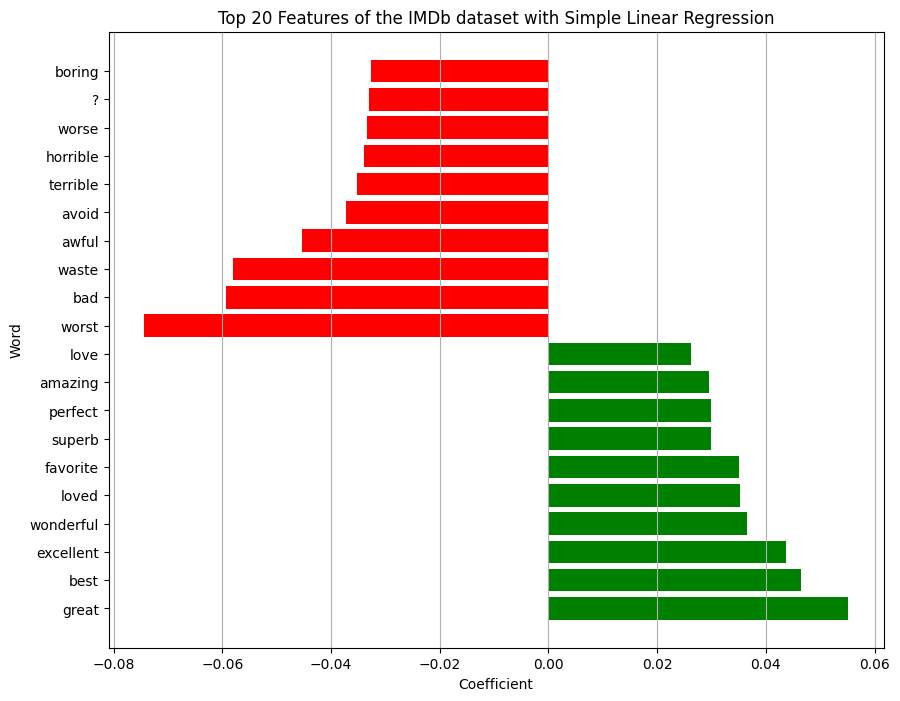

In [94]:
top_feature_names = top_10["Word"].tolist() + bottom_10["Word"].tolist()
top_coefficients = (-np.sort(-coefficients)[:10]).tolist() + np.sort(coefficients)[:10].tolist()

# plotting
plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in top_coefficients]
plt.barh(top_feature_names, top_coefficients, color=colors)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.title('Top 20 Features of the IMDb dataset with Simple Linear Regression')
plt.grid(axis='x')
plt.show()

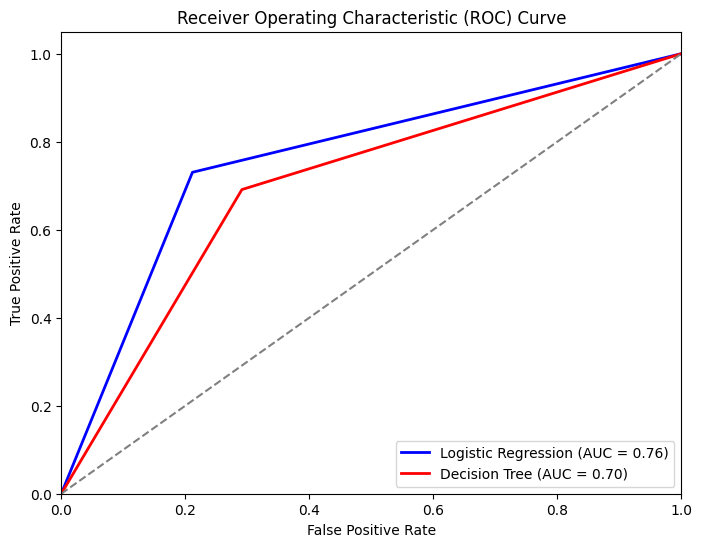

In [89]:
# ROC curve and ROC area for logistic regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary, y_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# ROC curve and ROC area for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test_binary, dt_y_pred)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [90]:
threshold = 5
all_y_binary = np.where(all_y > threshold, 1, 0)

/Users/martamenta/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/martamenta/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martamenta/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

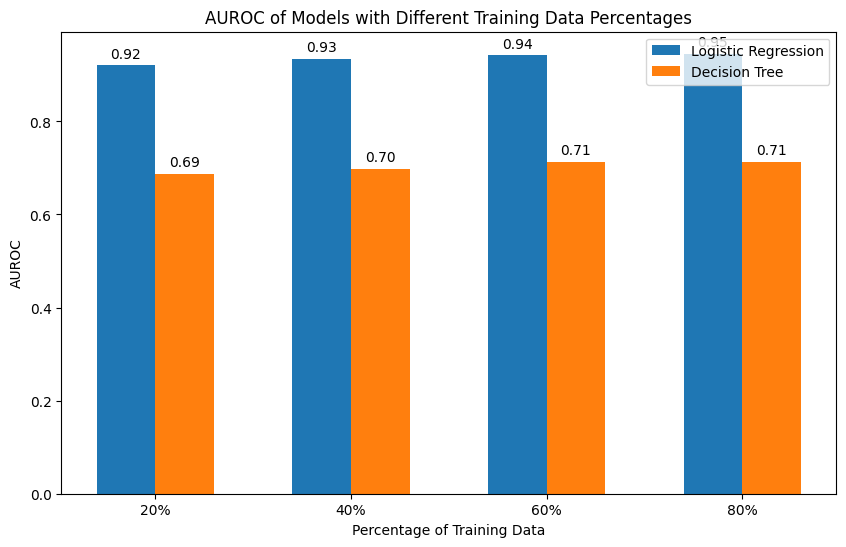

In [97]:
# define the percentages of training data
training_data_percentages = [0.2, 0.4, 0.6, 0.8]

# initialise lists to store AUROC values
auroc_lr = []
auroc_dt = []

# loop over different percentages of training data
for percentage in training_data_percentages:
    # split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y_binary, test_size=1 - percentage, random_state=42)
    
    # train logistic regression model
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)
    
    # train Decision Tree model
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    
    # predict probabilities for logistic regression
    y_pred_lr = lr_model.predict_proba(X_test)[:, 1]
    
    # predict probabilities for Decision Tree
    y_pred_dt = dt_model.predict_proba(X_test)[:, 1]
    
    # calculate AUROC for logistic regression
    auroc_lr.append(roc_auc_score(y_test, y_pred_lr))
    
    # calculate AUROC for Decision Tree
    auroc_dt.append(roc_auc_score(y_test, y_pred_dt))

# plot the AUROC values
plt.figure(figsize=(10, 6))
bars_lr = plt.bar(np.arange(len(training_data_percentages)) - 0.15, auroc_lr, width=0.3, label='Logistic Regression')
bars_dt = plt.bar(np.arange(len(training_data_percentages)) + 0.15, auroc_dt, width=0.3, label='Decision Tree')
plt.xticks(np.arange(len(training_data_percentages)), [f"{int(p * 100)}%" for p in training_data_percentages])
plt.xlabel('Percentage of Training Data')
plt.ylabel('AUROC')
plt.title('AUROC of Models with Different Training Data Percentages')
plt.legend()

# adding annotations with AUROC values above each bar
for bars in [bars_lr, bars_dt]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.show()


# 20 newsgroups Dataset

The five chosen categories of newsgroups are the following:
    1. comp.graphics
    2. soc.religion.christian
    3. rec.sport.hockey
    4. sci.space
    5. talk.politics.guns

In [ ]:
#importing the dataset and downloads 
nltk.download('stopwords')
nltk.download('punkt')

#fetching the dataset (all data)
all_newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
all_newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
print("Length of training data (before choosing 5 categories): " + str(len(all_newsgroups_train.data)))
print ("Length of test data (before choosing 5 categories): " + str(len(all_newsgroups_test.data)))

#Choosing 5 categories
chosen_categories = ['comp.graphics', 'soc.religion.christian', 'rec.sport.hockey', 'sci.space', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train', categories=chosen_categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=chosen_categories, remove=('headers', 'footers', 'quotes'))

print("Length of training data (after choosing 5 categories): " + str(len(newsgroups_train.data)))
print ("Length of test data (after choosing 5 categories): " + str(len(newsgroups_test.data)) + '\n')

#for data visualization purposes, printing the head of the dataset
newsgroups_train_df = pd.DataFrame({'text': newsgroups_train.data, 'category': newsgroups_train.target})
print("Train Data Frame")
display(newsgroups_train_df.head())

newsgroups_test_df = pd.DataFrame({'text': newsgroups_test.data, 'category': newsgroups_test.target})
print("Test Data Frame")
display(newsgroups_test_df.head())

#note the corresponding number values for each category
for index, category in enumerate(newsgroups_train.target_names):
    print(f'Category Number: {index} -> Category Name: {category}')

Now that we have selected a subset of the data, we will visualize its distribution to ensure the categories of news are relatively well balanced. 

In [ ]:
#visualize the distribution of categories selected through a bar graph

#count the number of documents in each category
category_counts = newsgroups_train_df['category'].value_counts()

#convert the categories numbers to their names
category_names = [newsgroups_train.target_names[i] for i in category_counts.index]

#calculate the category percentages
category_percentages = category_counts / category_counts.sum() * 100

#plot the distribution 
plt.figure(figsize=(5,2.5))
plt.bar(category_names, category_counts)
plt.title('Distribution of Categories for Training Data')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()

# Plot a pie chart
plt.figure(figsize=(4,4))
plt.pie(category_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Documents in Each Category')
plt.show()

#same steps for the test data
category_counts = newsgroups_test_df['category'].value_counts()
category_names = [newsgroups_test.target_names[i] for i in category_counts.index]
category_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(5, 2.5))
plt.bar(category_names, category_counts)
plt.title('Distribution of Categories for Test Data')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Documents in Each Category')
plt.show()

Now, we have seen our data in both training and testing is well balanced. So we can continue with further preprocessing steps. 

Note the folowing numbers and their associated category names:

Category Number: 0 -> Category Name: comp.graphics
Category Number: 1 -> Category Name: rec.sport.hockey
Category Number: 2 -> Category Name: sci.space
Category Number: 3 -> Category Name: soc.religion.christian
Category Number: 4 -> Category Name: talk.politics.guns

## Data Preprocessing

Several preprocessing steps are required before training our model. We will lowercase the entries, remove punctuation, special characters and numbers as well as double spaces. We will then remove stopwords and filter out any empty entires. 

In [ ]:
#Preprocessing steps ============
#TRAINING DATA =============================
#lowercase the entries
newsgroups_train.data = [text.lower() for text in newsgroups_train.data]
#regex to remove tags, etc.
newsgroups_train.data = [re.sub(r'(<br\s*/>\s*)+|(/)|(\n)|(-)', '', text) for text in newsgroups_train.data]
#removing punctuation
newsgroups_train.data = [text.translate(str.maketrans('', '', string.punctuation)) for text in newsgroups_train.data]
#removing numbers and any other special characters
newsgroups_train.data = [re.sub(r'[^a-z\s]', '', text) for text in newsgroups_train.data]
#remove any double spaces
newsgroups_train.data = [re.sub(r'\s+', ' ', text) for text in newsgroups_train.data]

# Filter out empty entries and update both data and target
filtered_data = []
filtered_target = []
for text, target in zip(newsgroups_train.data, newsgroups_train.target):
    if text.strip():
        filtered_data.append(text)
        filtered_target.append(target)

newsgroups_train.data = filtered_data
newsgroups_train.target = np.array(filtered_target)

#removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    entry_nostopwords = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(entry_nostopwords)

#call remove_stopwords function
newsgroups_train.data = [remove_stopwords(entry) for entry in newsgroups_train.data]

# Create a DataFrame for visualization
newsgroups_train_df_cleaned = pd.DataFrame({'entry (Data)': newsgroups_train.data, 'target': newsgroups_train.target})
display(newsgroups_train_df_cleaned.head())

#TEST DATA =============================
#lowercase the entries
newsgroups_test.data = [text.lower() for text in newsgroups_test.data]
#regex to remove tags, etc.
newsgroups_test.data = [re.sub(r'(<br\s*/>\s*)+|(/)|(\n)|(-)', '', text) for text in newsgroups_test.data]
#removing punctuation
newsgroups_test.data = [text.translate(str.maketrans('', '', string.punctuation)) for text in newsgroups_test.data]
#removing numbers and any other special characters
newsgroups_test.data = [re.sub(r'[^a-z\s]', '', text) for text in newsgroups_test.data]
#remove any double spaces
newsgroups_test.data = [re.sub(r'\s+', ' ', text) for text in newsgroups_test.data]

# Filter out empty entries and update both data and target
filtered_data = []
filtered_target = []
for text, target in zip(newsgroups_test.data, newsgroups_test.target):
    if text.strip():
        filtered_data.append(text)
        filtered_target.append(target)
        
newsgroups_test.data = filtered_data
newsgroups_test.target = np.array(filtered_target)

#call remove_stopwords 
newsgroups_test.data = [remove_stopwords(entry) for entry in newsgroups_test.data]

y_newsgroups_train = newsgroups_train.target

### Converting text to vectors 

Using Count Vectorizer we will count the occurences of each token in each document. 
We used a minimum threshold of 0.01 and a maximum threshold of 0.5.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df= 0.01, max_df= 0.5)
X_train_counts = count_vect.fit_transform(newsgroups_train.data)

print("Number of unique words in the training data: " + str(X_train_counts.shape[1]))
print("The shape of the training data: " + str(X_train_counts.shape))

#perform the same on the test data
X_test_counts = count_vect.transform(newsgroups_test.data)

print("Number of unique words in the test data: " + str(X_test_counts.shape[1]))
print("The shape of the test data: " + str(X_test_counts.shape))


Now, we will use tf-idf so that we can remove the potential issue of logner documents having a higher average count for words than shorter documents. 

Tf-idf will downscale the weight of words that occur in many documents are are less informative.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_newsgroups = tfidf_transformer.fit_transform(X_train_counts)

#perform same on test dataset
X_test_newsgroups = tfidf_transformer.fit_transform(X_test_counts)

print("The shape of the training data after TF-IDF: " + str(X_train_newsgroups.shape))

## Using Mutual Information (MI) to select features

We will use mutual informations cores to determine which features are most important for making predictions. This will tell us the words that are most important in predicting the category of news.

One hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Before encoding
print("The shape of the training target: " + str(newsgroups_train.target.shape))
print("Matrix of y_train before one hot encoding: ", newsgroups_train.target)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot_encoder.fit_transform(newsgroups_train.target.reshape(-1, 1))

# After encoding
print("The shape of the one-hot encoded training target: " + str(y_train_onehot.shape))
print("Matrix of y_train after one hot encoding: \n", y_train_onehot)

#perform the same on the test dataset
y_test_onehot = onehot_encoder.fit_transform(newsgroups_test.target.reshape(-1, 1))

#update variables
y_train_newsgroups = y_train_onehot
y_test_newsgroups = y_test_onehot

In [ ]:
from sklearn.metrics import mutual_info_score

#number of classes
num_classes = len(newsgroups_train.target_names)

#number of features
num_features = X_train_counts.shape[1]

top_features_classes = {}

for y_index, class_name in enumerate(newsgroups_train.target_names):
    #Debugging purposes
    #print("Shape of X_train_counts:", X_train_counts.shape)
    #print("Shape of y_train_onehot:", y_train_onehot.shape)
    
    # Create a binary array for the current class
    y_bin = y_train_onehot[:, y_index]

    # Calculate MI scores for each feature
    mi_scores = [mutual_info_score(X_train_counts[:, i].toarray().flatten(), y_bin) for i in range(num_features)]


    # Get the top 100 features
    top_indices = np.argsort(mi_scores)[::-1][:100]
    
    # Get the feature names and scores
    top_features = [count_vect.get_feature_names_out()[i] for i in top_indices]
    max_mi_scores = [mi_scores[i] for i in top_indices]

    # storing the top 100 features
    top_features_classes[class_name] = list(zip(top_features, max_mi_scores))

# # for vizualization purposes, print the top 100 features for each class
# for class_name, features in top_features_classes.items():
#     print(f"Top 100 features for {class_name}:")
#     for feature, score in features:
#         print(f"{feature}: {score}")
#     print()
    
# convert to a data fram
top_features_df = pd.DataFrame(top_features_classes)

#displaying the top 10 words for each news category
display(top_features_df.head(10))

In [ ]:
# Take the union of the top 100 features of each class
top_features_union = set().union(*top_features_classes.values())

print("Number of unique words in the top 100 features for each class: " + str(len(top_features_union)))

# Convert the set to a list
top_features_union_list = list(top_features_union)


## Implementing the Multiclass Regression model

In [ ]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


## Splitting the dataset into training, testing and validation sets

The variables we will use for the 20 news dataset are the following:

X_train_newsgroups
y_train_newsgroups
X_validate_newsgroups
y_validate_newsgroups
X_test_newsgroups
y_test_newsgroups

In [ ]:
from sklearn.model_selection import train_test_split

X_train_newsgroups, X_validate_newsgroups, y_train_newsgroups, y_validate_newsgroups = train_test_split(X_train_newsgroups, y_train_newsgroups, test_size = 0.3, random_state = 5, shuffle = True)

#print the shapes of all the sets
print("The shape of the training set: " + str(X_train_newsgroups.shape))
print("The shape of the validation set: " + str(X_validate_newsgroups.shape))
print("The shape of the test set: " + str(X_test_counts.shape))


### Evaluation: Multi-class prediction classification accuracy 

First, we will fit the model and ensure there is no overfitting. 

In [ ]:
#make sure we are dealing with dense arrays 
X_train_newsgroups = X_train_newsgroups.toarray()
X_validate_newsgroups = X_validate_newsgroups.toarray()
X_test_newsgroups = X_test_newsgroups.toarray()

#create the model
model = Multinomial_logistic(nFeatures=X_train_newsgroups.shape[1], nClasses=y_train_onehot.shape[1])

#checking the gradient
print("Gradient for multiclass: " + str(model.check_grad(X_train_newsgroups, y_train_newsgroups)))

#fit the model 
model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)

ce_train, ce_valid = model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)
#plot a figure to ensure no overfitting 
plt.clf()
plt.plot(ce_train/X_train_newsgroups.shape[0], label='train')
plt.plot(ce_valid/X_validate_newsgroups.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)


We have verfied from the above plot that both training and validation error curves are continuing to decrease for all the iterations. Therefore, we can conlcude there are no errors in overfitting and can evaluate our model.

#### Evaluating the Classification Accuracy 

In [ ]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [ ]:
train_accuracy = evaluate(model.predict(X_train_newsgroups), y_train_newsgroups)
valid_accuracy = evaluate(model.predict(X_validate_newsgroups), y_validate_newsgroups)
test_accuracy = evaluate(model.predict(X_test_newsgroups), y_test_newsgroups)

print("Training accuracy : " + str(train_accuracy))
print("Validation accruacy : " + str(valid_accuracy))
print("Test accuracy : " + str(test_accuracy))

multiclass_accuracy = test_accuracy

### Comparing multi-label classification with Decision Tree 

We are going to begin by comparing DT performance and our multi-class model with default hyperparameters and then will perform optimizations for tree depth and classification hyperparameters.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#make a pipeline for decision tree 

pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier()),
])

pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)

y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)

accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)

newsgroups_accuracy_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Multi-class'],
    'Accuracy': [accuracy_dt, multiclass_accuracy]
})

#display the df
display(newsgroups_accuracy_df)


### Experimenting with max depth optimization

Now, we will perform the same comparison but with max depth optimization. 

In [ ]:
# Initialize maximum accuracy and corresponding depth
max_accuracy_dt = 0
best_depth = 0

#increments of max depth 
for i in [5,10,20,30,40,50,75,100,225,500,1000,2225,3000,5000]:
    pipeline_dt = Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=i)),
    ])

    pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)

    y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)

    accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)
    
    # Update max accuracy and depth if current accuracy is greater
    if accuracy_dt > max_accuracy_dt:
        max_accuracy_dt = accuracy_dt
        best_depth = i

print(f"The maximum accuracy is {max_accuracy_dt} at depth {best_depth}")

### Task 3: Running Experiments


##### Comparing the accuracy of the multiclass model with DT as a function of the size of the dataset.

In [ ]:
#make a list of training sizes to test
training_sizes = [0.2, 0.4, 0.6, 0.8]

#initialize the list of accuracies
mlr_accuracies = []
dt_accuracies = []

#loop through the training sizes
for size in training_sizes:
    #split the data
    X_train_newsgroups, X_validate_newsgroups, y_train_newsgroups, y_validate_newsgroups = train_test_split(X_train_newsgroups, y_train_newsgroups, test_size = size, random_state = 5, shuffle = True)
    
    #create the model
    model = Multinomial_logistic(nFeatures=X_train_newsgroups.shape[1], nClasses=y_train_onehot.shape[1])
    
    #fit the model
    model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)
    
    #get the accuracy
    train_accuracy = evaluate(model.predict(X_train_newsgroups), y_train_newsgroups)
    valid_accuracy = evaluate(model.predict(X_validate_newsgroups), y_validate_newsgroups)
    test_accuracy = evaluate(model.predict(X_test_newsgroups), y_test_newsgroups)
    
    #append the accuracy to the list
    mlr_accuracies.append(test_accuracy)
    
    #create the pipeline for decision tree
    pipeline_dt = Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=best_depth)),
    ])
    
    #fit the model
    pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)
    
    #get the accuracy
    y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)
    accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)
    
    #append the accuracy to the list
    dt_accuracies.append(accuracy_dt)
    
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, mlr_accuracies, marker='o', label='Multinomial Logistic Regression')
plt.plot(training_sizes, dt_accuracies, marker='s', label='Decision Tree')
plt.title('Model Accuracy as a Function of Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.xticks(training_sizes, [f'{int(size*100)}%' for size in training_sizes])
plt.legend()
plt.grid(True)
plt.show()

x = np.arange(len(training_sizes))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, mlr_accuracies, width, label='Multiclass Regression')
rects2 = ax.bar(x + width/2, dt_accuracies, width, label='Decision Tree')

ax.set_xlabel('Training Data Size')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracies of MLR and DT on Test Data')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(size*100)}%' for size in training_sizes])
ax.legend()

plt.show()

##### Heatmap for top 5 most positive features for each class. 

In [ ]:
#list of classes 
class_order = ['comp.graphics', 'rec.sport.hockey', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']

rows_list = []

# get the top 5 features for each class and append them 
for class_name in class_order:
    features = top_features_classes[class_name][:5]
    for feature, score in features:
        rows_list.append({'Feature': feature, 'Class': class_name, 'Score': score})

features_df = pd.DataFrame(rows_list)

features_df['Class'] = pd.Categorical(features_df['Class'], categories=class_order, ordered=True)

features_df = features_df.sort_values(by='Class')

pivoted_df = features_df.pivot(index='Feature', columns='Class', values='Score')

# Fill in any blanks with 0
pivoted_df = pivoted_df.fillna(0)

plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Top 5 Features Heatmap by Class')
plt.xlabel('Class')
plt.ylabel('Feature')
plt.show()
